<a href="https://colab.research.google.com/github/mohyunyang/My_Kaggle/blob/main/(Step3)Bike_Sharing_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

! kaggle competitions download -c bike-sharing-demand

!unzip bike-sharing-demand.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 67.3MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
# 이상치제거 weather = 4가 아닌 것들만 추출
train = train[train['weather']!=4] 

In [ ]:
all_data = pd.concat([train, test], ignore_index = True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [ ]:
# 파생피처 추가
from datetime import datetime

# 날짜 피처 생성
print(all_data['datetime'][0])
print(all_data['datetime'][0].split())
print(all_data['datetime'][0].split()[0])

all_data['date'] = all_data['datetime'].apply( lambda x : x.split()[0])
print(all_data['date'][0])

# 년
all_data['year'] = all_data['date'].apply( lambda x : x.split('-')[0])
print(all_data['year'][0])

# 월
all_data['month'] = all_data['date'].apply( lambda x : x.split('-')[1])
print(all_data['month'][0])

# 시간
all_data['hour'] = all_data['datetime'].apply( lambda x : x.split()[1].split(':')[0])
print(all_data['hour'][0])

# 요일
all_data['weekday'] = all_data['date'].apply( lambda x : datetime.strptime(x, '%Y-%m-%d').weekday())
print(all_data['weekday'][0])

2011-01-01 00:00:00
['2011-01-01', '00:00:00']
2011-01-01
2011-01-01
2011
01
00
5


In [ ]:
# 피쳐제거
drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']
all_data = all_data.drop(drop_features, axis=1)
all_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5


In [ ]:
# 데이터 나누기 ('count'가 있는 건 train, 없는건 test)
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

In [ ]:
# 'count' 제거
X_train = X_train.drop('count', axis=1)
X_test = X_test.drop('count', axis=1)

In [ ]:
# 타겟값
y = train['count']

In [ ]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
  # 지수변환
  if convertExp:
    y_true = np.exp(y_true) # exp : 지수변환 np함수
    y_pred = np.exp(y_pred)
  
  # 로그변환 후 결측값을 0으로 변환
  log_ture = np.nan_to_num(np.log(y_true+1)) # np.nan_to_num : 결측값을 0으로 바꾸는 np함수
  log_pred = np.nan_to_num(np.log(y_pred+1))  

  # RMSLE 계산
  output = np.sqrt(np.mean((log_ture - log_pred)**2))
  return output

In [ ]:
print(f'선형회귀의 RMSLE 값 : {rmsle(log_y, pred, True):.4f}')

# 성능개선 

## 릿지

규제를 적용해 과대적합을 막는 회귀 모델

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

- 그리드서치 객체 생성

` 비교 검증해볼 하이퍼파라미터 값 목록`

` 대상 모델 `

` 교차 검증용 평가수단(평가함수) `

In [ ]:
# 하이퍼파라미터 값 목록
ridge_params = {'max_iter' : [3000], 'alpha' : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수 (RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator= ridge_model,   # 평가자 : 릿지모델
                                      param_grid= ridge_params, # 파라미터격자 : 파라미터 값 목록 
                                      scoring= rmsle_scorer,    # 평가지표
                                      cv= 5)                    # 교차검증

In [ ]:
# 그리드서치 수행
log_y = np.log(y) # 타겟값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [ ]:
print('최적의 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적의 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


In [ ]:
# 성능검증
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)
print(preds[:5])
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

[2.19542191 2.27906913 2.38252998 2.59670259 2.70016344]
릿지 회귀 RMSLE 값 : 1.0205


## 라쏘회귀모델

In [ ]:
from sklearn.linear_model import Lasso

# 모델생성
lasso_model = Lasso()

# 하이퍼파라미터값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter': [3000], 'alpha': lasso_alpha}

# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator= lasso_model,
                                      param_grid = lasso_params,
                                      scoring= rmsle_scorer,
                                      cv=5)

log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print("최적의 파라미터:", gridsearch_ridge_model.best_params_)

최적의 파라미터: {'alpha': 0.1, 'max_iter': 3000}


In [ ]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 :, {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 :, 1.0205


## 랜덤포레스트 회귀 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

# 그리드객체 생성
rf_params = {'random_state': [42], 'n_estimators': [100, 120, 140]}  # n_estimators = 결정트리개수
gridsearch_rf_model = GridSearchCV(estimator= rf_model,
                                   param_grid= rf_params,
                                   scoring= rmsle_scorer,
                                   cv=5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_rf_model.fit(X_train, log_y)
print('최적의 파라미터 :', gridsearch_rf_model.best_params_)

최적의 파라미터 : {'n_estimators': 140, 'random_state': 42}


In [ ]:
preds = gridsearch_rf_model.best_estimator_.predict(X_train)
print(preds[:5])
print(f'랜덤포레스트 회귀 RMSLE 값 {rmsle(log_y, preds, True):.4f}')

[2.9235532  3.42733939 3.2188421  2.48250647 0.35385269]
랜덤포레스트 회귀 RMSLE 값 0.1127


# 예측 및 결과 제출

Text(0.5, 1.0, 'Predict Test Data Distribution')

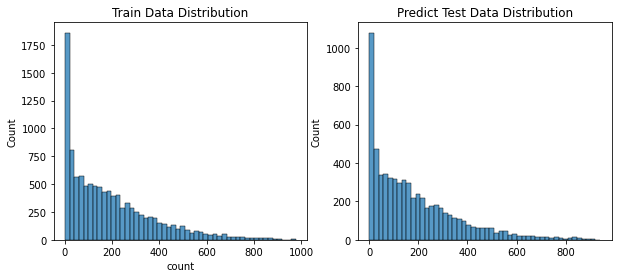

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

rf_preds = gridsearch_rf_model.best_estimator_.predict(X_test)

fig, axes = plt.subplots(1,2, figsize = (10,4))

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(rf_preds), bins=50, ax=axes[1])
axes[1].set_title('Predict Test Data Distribution')

In [ ]:
submission = pd.read_csv('sampleSubmission.csv')

In [ ]:
submission['count'] = np.exp(rf_preds) # 지수변환한 값을 저장
submission.to_csv('submission1.csv', index = False)

In [ ]:
submission[:5]

,datetime,count
0,2011-01-20 00:00:00,12.127016
1,2011-01-20 01:00:00,4.981274
2,2011-01-20 02:00:00,3.209022
3,2011-01-20 03:00:00,3.503956
4,2011-01-20 04:00:00,2.680269
